In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor
import shap
from shap import Explanation
from utils.shap import plot_shap_bar_side_by_side, get_shap_comparison_df, plot_shap_difference_bar, plot_shap_violin_comparison

shap.initjs()
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("data/preprocessed_bank_data.csv")
X = df.drop(columns='y')
y = df['y']
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
predictor = TabularPredictor.load("models/my_predictor")

In [ ]:
fi_df = predictor.feature_importance(pd.concat([X_valid, y_valid], axis=1), 
                                    model="RandomForest_BAG_L1_FULL", 
                                    num_shuffle_sets=6)
fi_df

,importance,stddev,p_value,n,p99_high,p99_low
nr.employed,0.095619,0.013263,0.000005,6,0.117452,0.073787
euribor3m,0.082546,0.009392,0.000002,6,0.098007,0.067085
emp.var.rate,0.074362,0.007875,0.000001,6,0.087326,0.061399
pdays,0.043748,0.008889,0.000035,6,0.058379,0.029116
cons.price.idx,0.027307,0.004218,0.000009,6,0.034250,0.020364
cons.conf.idx,0.026134,0.009185,0.000468,6,0.041253,0.011014
contact,0.023369,0.007072,0.000233,6,0.035010,0.011727
poutcome,0.022354,0.010774,0.001914,6,0.040090,0.004619
month,0.020446,0.005214,0.000104,6,0.029028,0.011863
age,0.013866,0.004538,0.000336,6,0.021336,0.006396


Looking at the feature importance table, we can see that nr.employed, euribor3m, and emp.var.rate play an important role in our prediction. It makes sense that economic indicators are significant because when the economy is stable (low inflation, high employment, and strong consumer confidence), clients are more open to banking offers. Judging by the p-values, the majority of features have statistical significance.

## Shap values. 

In [6]:
predictor.model_names()

['RandomForest_BAG_L1',
 'ExtraTrees_BAG_L1',
 'WeightedEnsemble_L2',
 'RandomForest_BAG_L1_FULL',
 'ExtraTrees_BAG_L1_FULL',
 'WeightedEnsemble_L2_FULL']

In [11]:
class AutogluonWrapper:
    def __init__(self, predictor, feature_names):
        self.ag_model = predictor
        self.feature_names = feature_names
    
    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        return self.ag_model.predict_proba(X, as_multiclass=False)

In [13]:
feature_names = [col for col in X_train.columns if col != 'y']

In [14]:
ag_wrapper = AutogluonWrapper(predictor, feature_names)

In [15]:
baseline = X_valid.mode().iloc[0] 

In [16]:
explainer = shap.KernelExplainer(ag_wrapper.predict_binary_prob, baseline)

In [17]:
shap_values = explainer.shap_values(X_valid)

  0%|          | 0/8236 [00:00<?, ?it/s]

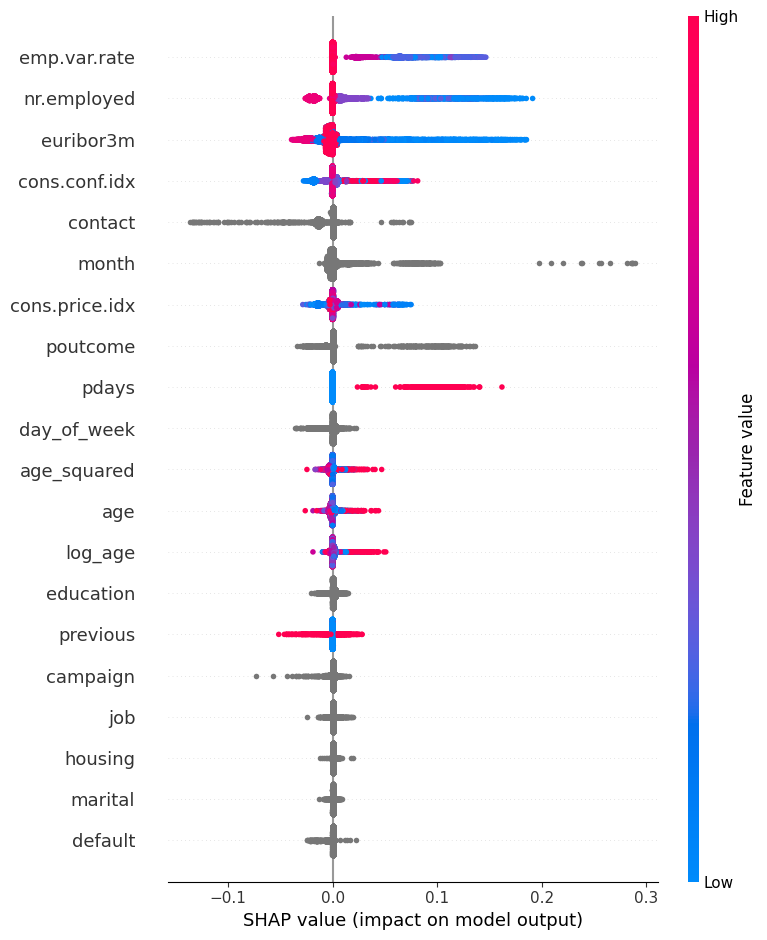

In [18]:
shap.summary_plot(shap_values, X_valid)

From the SHAP summary plot, we can conclude that economic indicators such as emp.var.rate, nr.employed, and euribor3m have the most significant impact on the model's predictions, with positive SHAP values indicating they increase the likelihood of the outcome (e.g., accepting a banking offer) when higher. Features like pdays and previous also show notable effects, while variables such as job, housing, and default have minimal influence, suggesting they play a lesser role in the model's decision-making process.

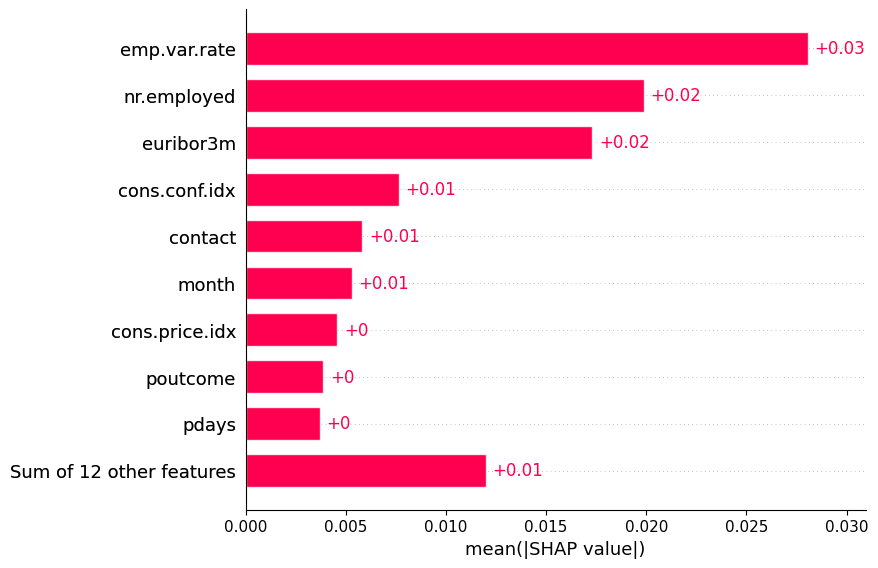

In [22]:
explanation = shap.Explanation(values=shap_values,
                              base_values=np.array([explainer.expected_value] * len(shap_values)),
                              data=X_valid,
                              feature_names=X_valid.columns.tolist())  # Add this line
shap.plots.bar(explanation)

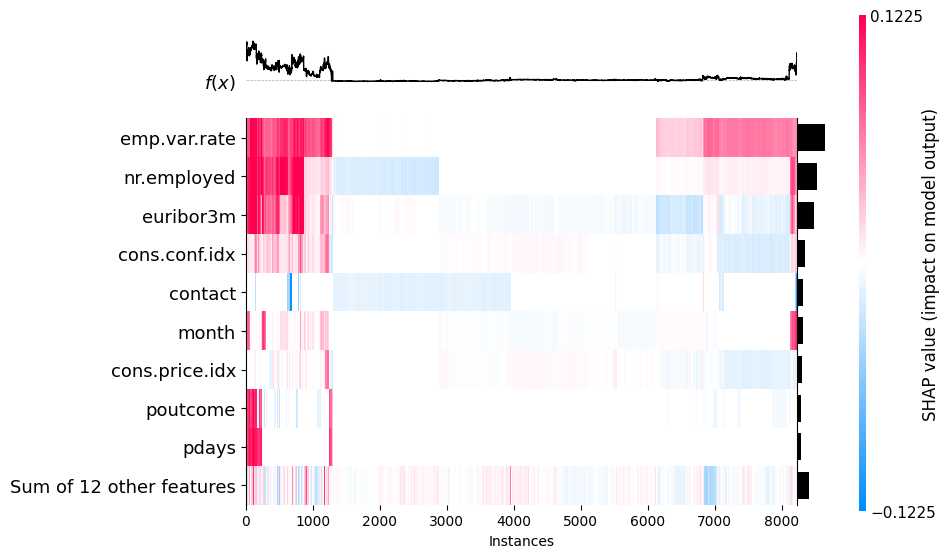

<Axes: xlabel='Instances'>

In [ ]:
shap.plots.heatmap(explanation)

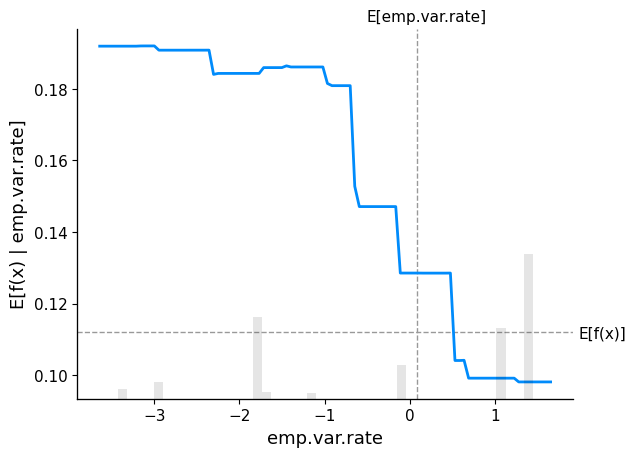

In [32]:
shap.plots.partial_dependence(
    "emp.var.rate", ag_wrapper.predict_binary_prob, X_valid, ice=False,
    model_expected_value=True, feature_expected_value=True
)

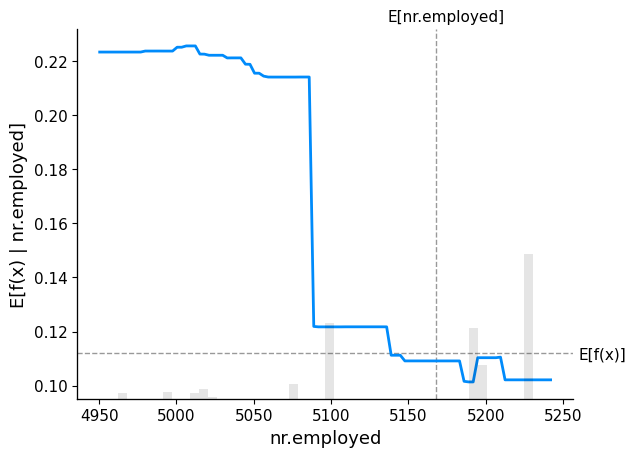

In [27]:
shap.plots.partial_dependence(
    "nr.employed", ag_wrapper.predict_binary_prob, X_valid, ice=False,
    model_expected_value=True, feature_expected_value=True
)

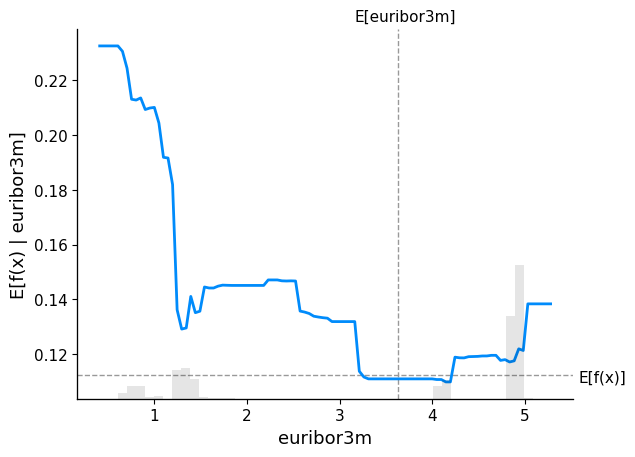

In [ ]:

shap.plots.partial_dependence(
    "euribor3m", ag_wrapper.predict_binary_prob, X_valid, ice=False,
    model_expected_value=True, feature_expected_value=True
)

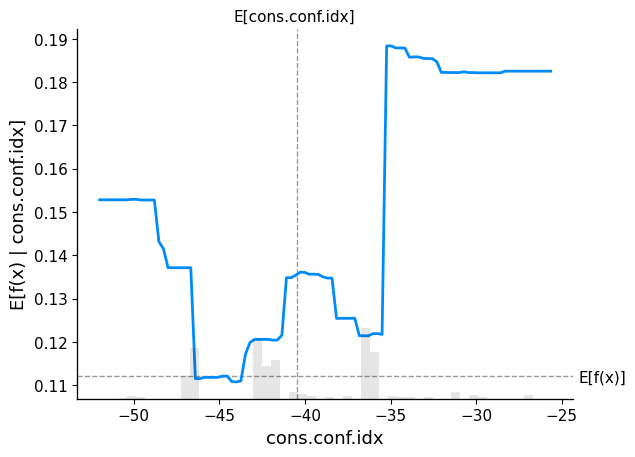

In [29]:
shap.plots.partial_dependence(
    "cons.conf.idx", ag_wrapper.predict_binary_prob, X_valid, ice=False,
    model_expected_value=True, feature_expected_value=True
)

The graphs above show a decrease in the likelihood of the positive class as the values of emp.var.rate, cons.price.idx, euribor3m, and nr.employed increase. In contrast, for cons.conf.idx, the likelihood increases as its value rises.

## Mistake analysis.

In [113]:
y_pred = predictor.predict(X_valid)

In [114]:
comparison_df = pd.DataFrame({
    'Actual': y_valid,
    'Predicted': y_pred
})

In [115]:
mistakes_df = comparison_df[comparison_df['Actual'] != comparison_df['Predicted']]

In [116]:
false_negatives = mistakes_df[(mistakes_df['Actual'] == 1) & (mistakes_df['Predicted'] == 0)]
true_negatives  = comparison_df[(comparison_df['Actual'] == 0) & (comparison_df['Predicted'] == 0)]

In [117]:
fn_index_locs = [X_valid.index.get_loc(i) for i in false_negatives.index]
tn_index_locs = [X_valid.index.get_loc(i) for i in true_negatives.index]

In [118]:
fn_expl = shap_values[np.array(fn_index_locs)]
tn_expl = shap_values[np.array(tn_index_locs)]

In [120]:
fn_pos = [X_valid.index.get_loc(i) for i in false_negatives.index]
fn_shap = shap_values[fn_pos]
fn_data = X_valid.iloc[fn_pos] 

In [121]:
fn_explanation = Explanation(
    values=fn_shap,
    base_values=np.array([explainer.expected_value] * len(fn_shap)),
    data=fn_data,
    feature_names=X_valid.columns.tolist()
)

In [122]:
tn_pos = [X_valid.index.get_loc(i) for i in true_negatives.index]
tn_shap = shap_values[tn_pos]
tn_data = X_valid.iloc[tn_pos]

In [123]:
tn_explanation = Explanation(
    values=tn_shap,
    base_values=np.array([explainer.expected_value] * len(tn_shap)),
    data=tn_data,
    feature_names=X_valid.columns.tolist()
)

In [ ]:
# Get predictions
y_pred = predictor.predict(X_valid)

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual': y_valid,
    'Predicted': y_pred
})

# Identify confusion matrix groups
false_negatives = comparison_df[(comparison_df['Actual'] == 1) & (comparison_df['Predicted'] == 0)]
false_positives = comparison_df[(comparison_df['Actual'] == 0) & (comparison_df['Predicted'] == 1)]
true_negatives  = comparison_df[(comparison_df['Actual'] == 0) & (comparison_df['Predicted'] == 0)]
true_positives  = comparison_df[(comparison_df['Actual'] == 1) & (comparison_df['Predicted'] == 1)]

# Map original DataFrame positions
def get_index_positions(df_group):
    return [X_valid.index.get_loc(i) for i in df_group.index]

fn_indices = get_index_positions(false_negatives)
fp_indices = get_index_positions(false_positives)
tn_indices = get_index_positions(true_negatives)
tp_indices = get_index_positions(true_positives)

# Get SHAP values and feature rows
fn_shap, fn_data = shap_values[np.array(fn_indices)], X_valid.iloc[fn_indices]
fp_shap, fp_data = shap_values[np.array(fp_indices)], X_valid.iloc[fp_indices]
tn_shap, tn_data = shap_values[np.array(tn_indices)], X_valid.iloc[tn_indices]
tp_shap, tp_data = shap_values[np.array(tp_indices)], X_valid.iloc[tp_indices]

# Wrap in SHAP Explanation objects
def create_explanation(shap_vals, data_rows):
    return Explanation(
        values=shap_vals,
        base_values=np.array([explainer.expected_value] * len(shap_vals)),
        data=data_rows,
        feature_names=X_valid.columns.tolist()
    )

fn_expl = create_explanation(fn_shap, fn_data)
fp_expl = create_explanation(fp_shap, fp_data)
tn_expl = create_explanation(tn_shap, tn_data)
tp_expl = create_explanation(tp_shap, tp_data)

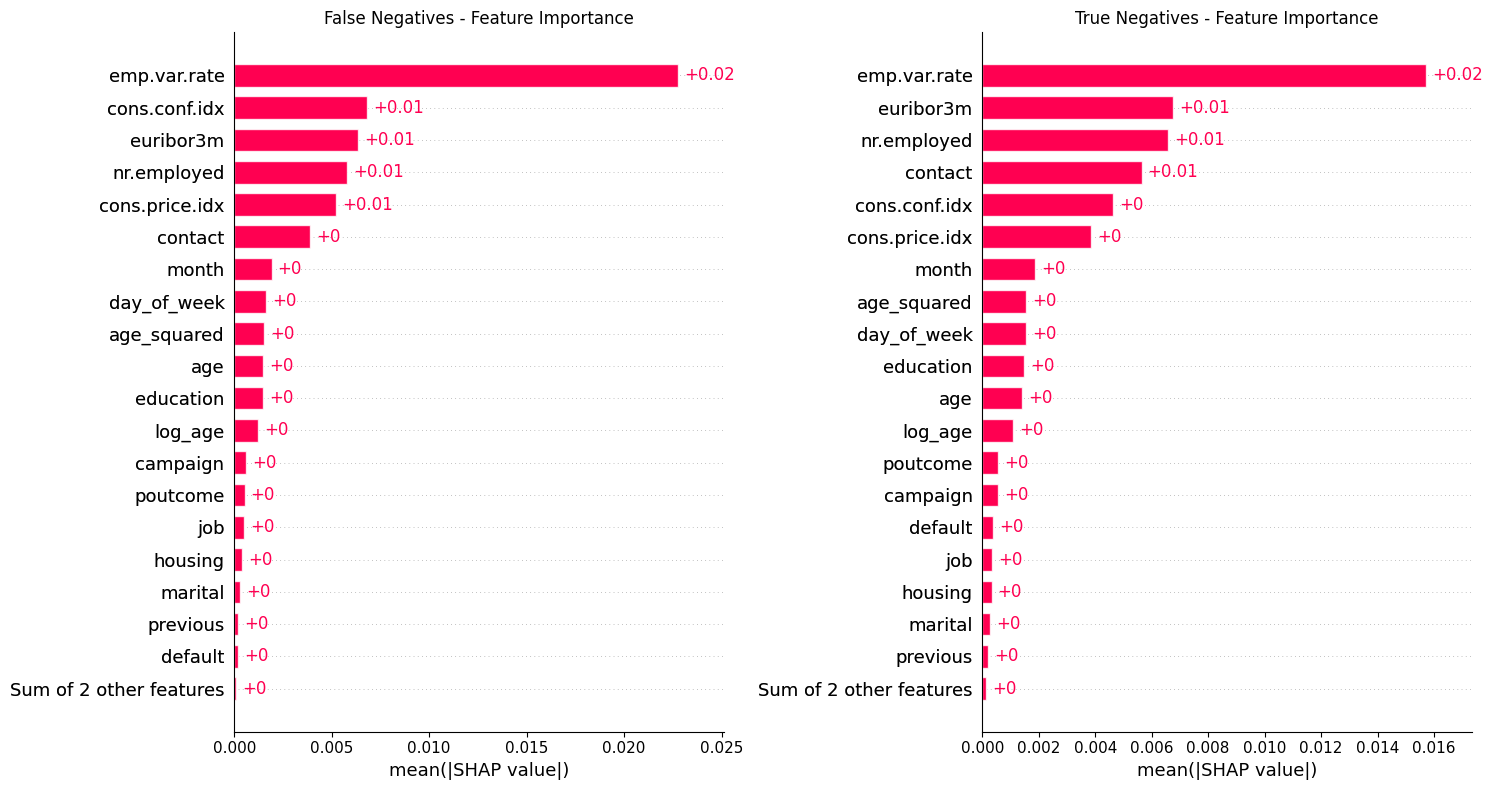

In [162]:
plot_shap_bar_side_by_side(fn_expl, tn_expl, 
                     title1="False Negatives - Feature Importance", 
                     title2="True Negatives - Feature Importance")

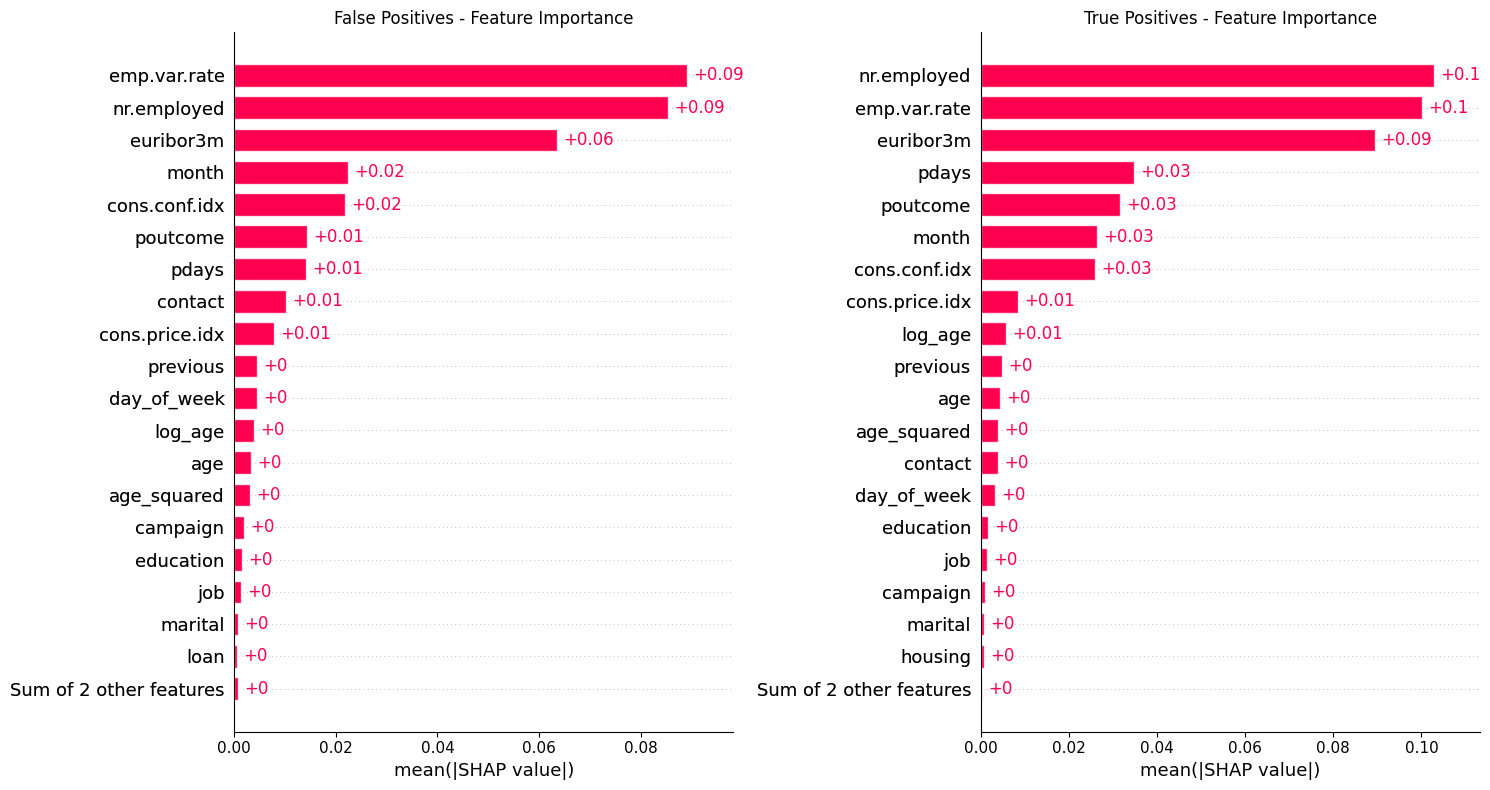

In [136]:
plot_shap_bar_side_by_side(fp_expl, tp_expl, 
                     title1="False Positives - Feature Importance", 
                     title2="True Positives - Feature Importance")

Economic factors such as employment rates, the number of employees, and interest rates strongly influence the model's predictions in both cases, so it’s a good idea to align marketing campaigns with favorable economic conditions. To avoid false positives, we may consider reviewing how heavily the model relies on these economic indicators or adding extra features that provide clearer signals.
Also, improving the handling of features  like previous outcomes and the days since last customer contact (such as feature engineering, transformation) might help reduce prediction errors.

In [138]:
# Calculate mean SHAP values
fn_mean = np.mean(fn_expl.values, axis=0)
tn_mean = np.mean(tn_expl.values, axis=0)
fp_mean = np.mean(fp_expl.values, axis=0)
tp_mean = np.mean(tp_expl.values, axis=0)

# Get feature names
feature_names = X_valid.columns.tolist()

In [151]:
# FN vs TN
comparison_df_fn_tn = get_shap_comparison_df(fn_mean, tn_mean, feature_names, 
                                             group1_label="False_Negatives", 
                                             group2_label="True_Negatives")
top_diff_features_fn = comparison_df_fn_tn.head(10)['Feature'].tolist()

# FP vs TP
comparison_df_fp_tp = get_shap_comparison_df(fp_mean, tp_mean, feature_names, 
                                             group1_label="False_Positives", 
                                             group2_label="True_Positives")
top_diff_features_fp = comparison_df_fp_tp.head(10)['Feature'].tolist()

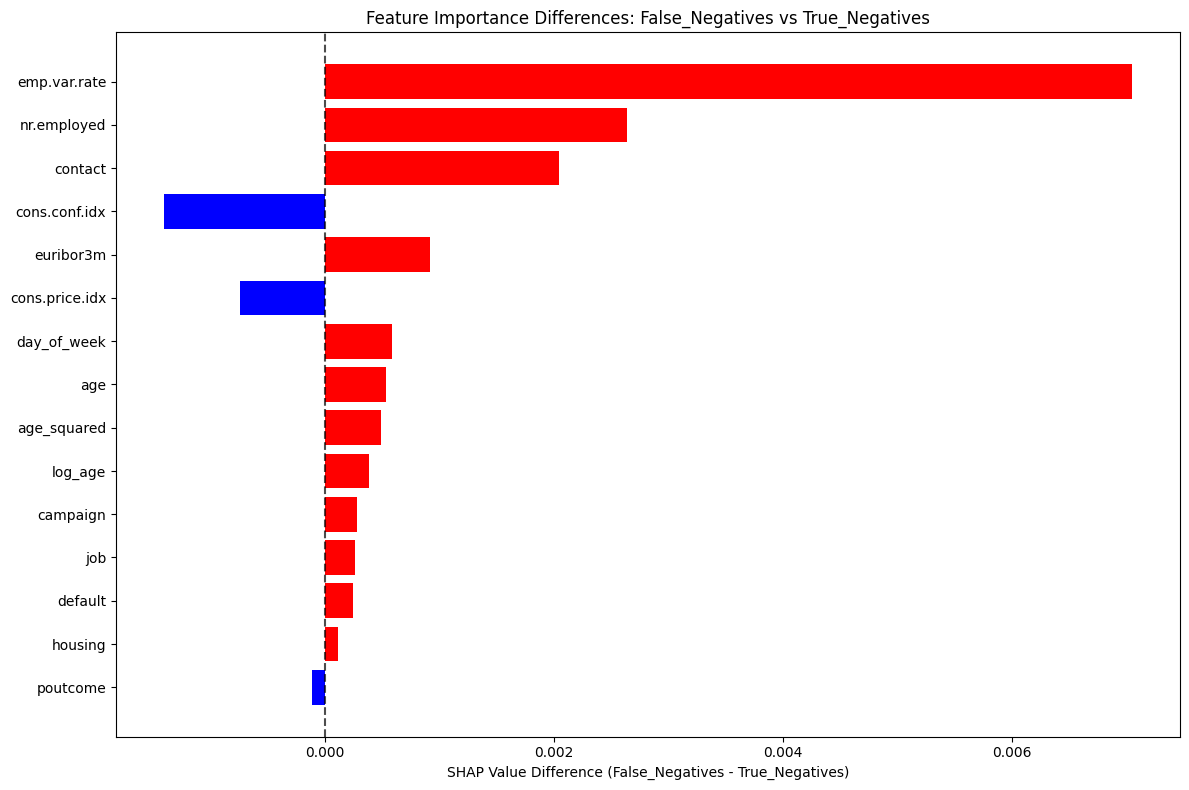

In [142]:
plot_shap_difference_bar(fn_mean, tn_mean, feature_names, 
                         group1_label="False_Negatives", 
                         group2_label="True_Negatives")

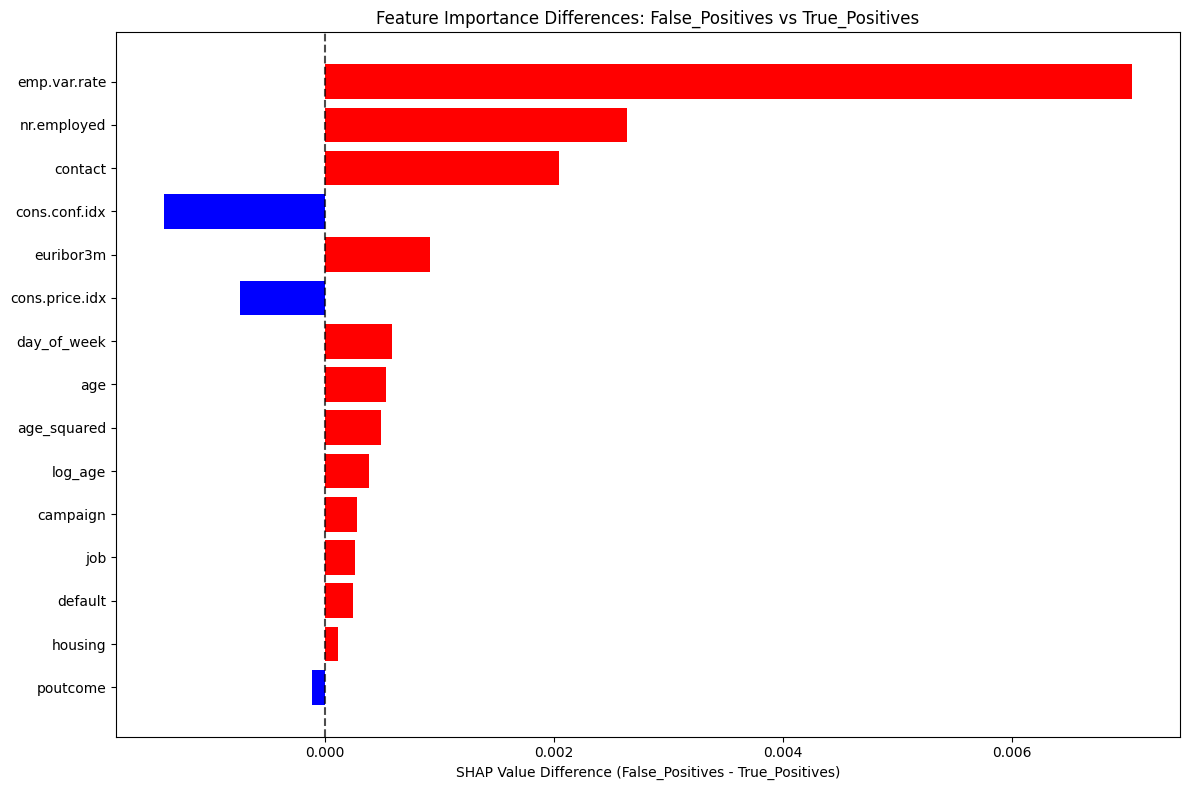

In [143]:
plot_shap_difference_bar(fp_mean, tp_mean, feature_names, 
                         group1_label="False_Positives", 
                         group2_label="True_Positives")

The model seems to rely more heavily on economic indicators like emp.var.rate, nr.employed, and euribor3m when it makes mistakes — especially false positives. This suggests the model might be overconfident during good economic conditions. Meanwhile, features like cons.conf.idx and cons.price.idx had more impact in correct predictions than in errors, meaning they might help the model make better decisions — but they’re currently underused. Overall, rebalancing the influence of these key economic features and giving more weight to consumer sentiment variables (concumer confidence index and conumer price index) could help reduce misclassifications.

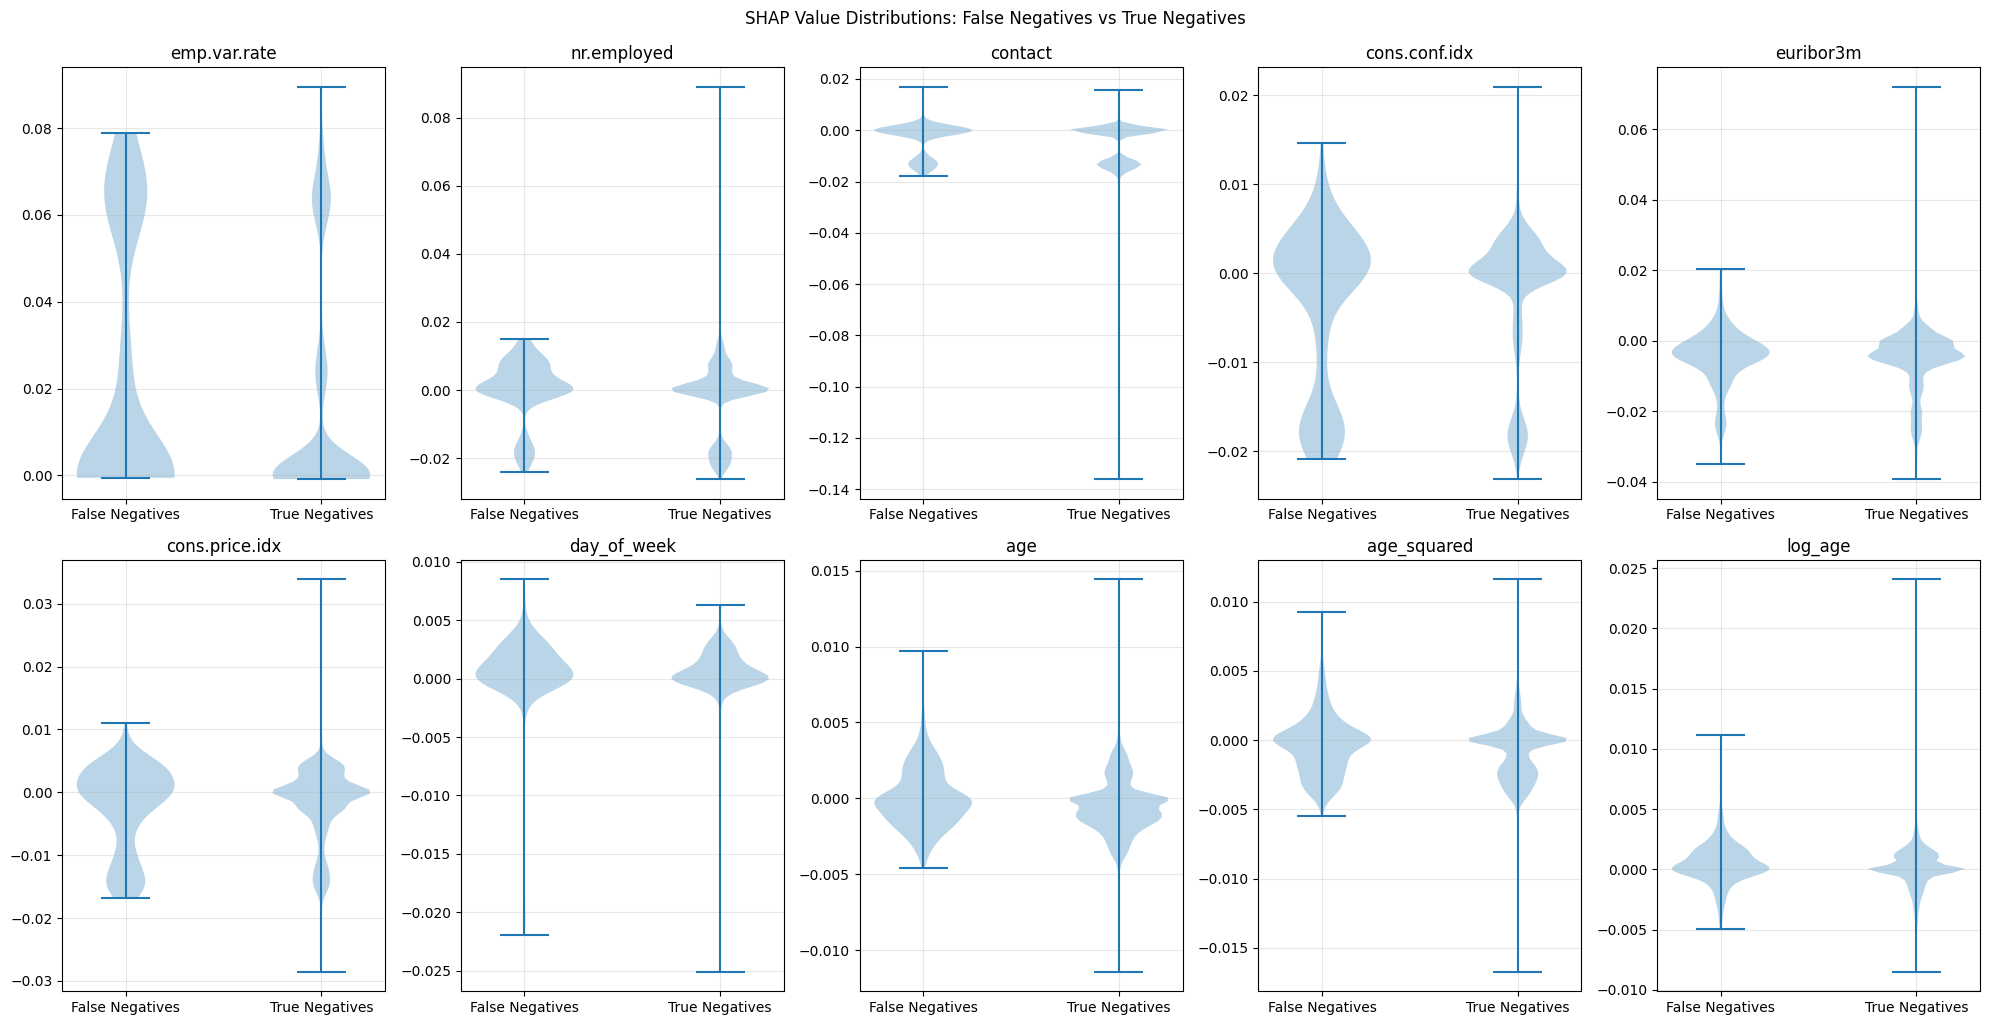

In [156]:
plot_shap_violin_comparison(
    expl1=fn_expl,
    expl2=tn_expl,
    feature_names=feature_names,
    comparison_df=comparison_df_fn_tn,
    group1_label="False Negatives",
    group2_label="True Negatives"
)

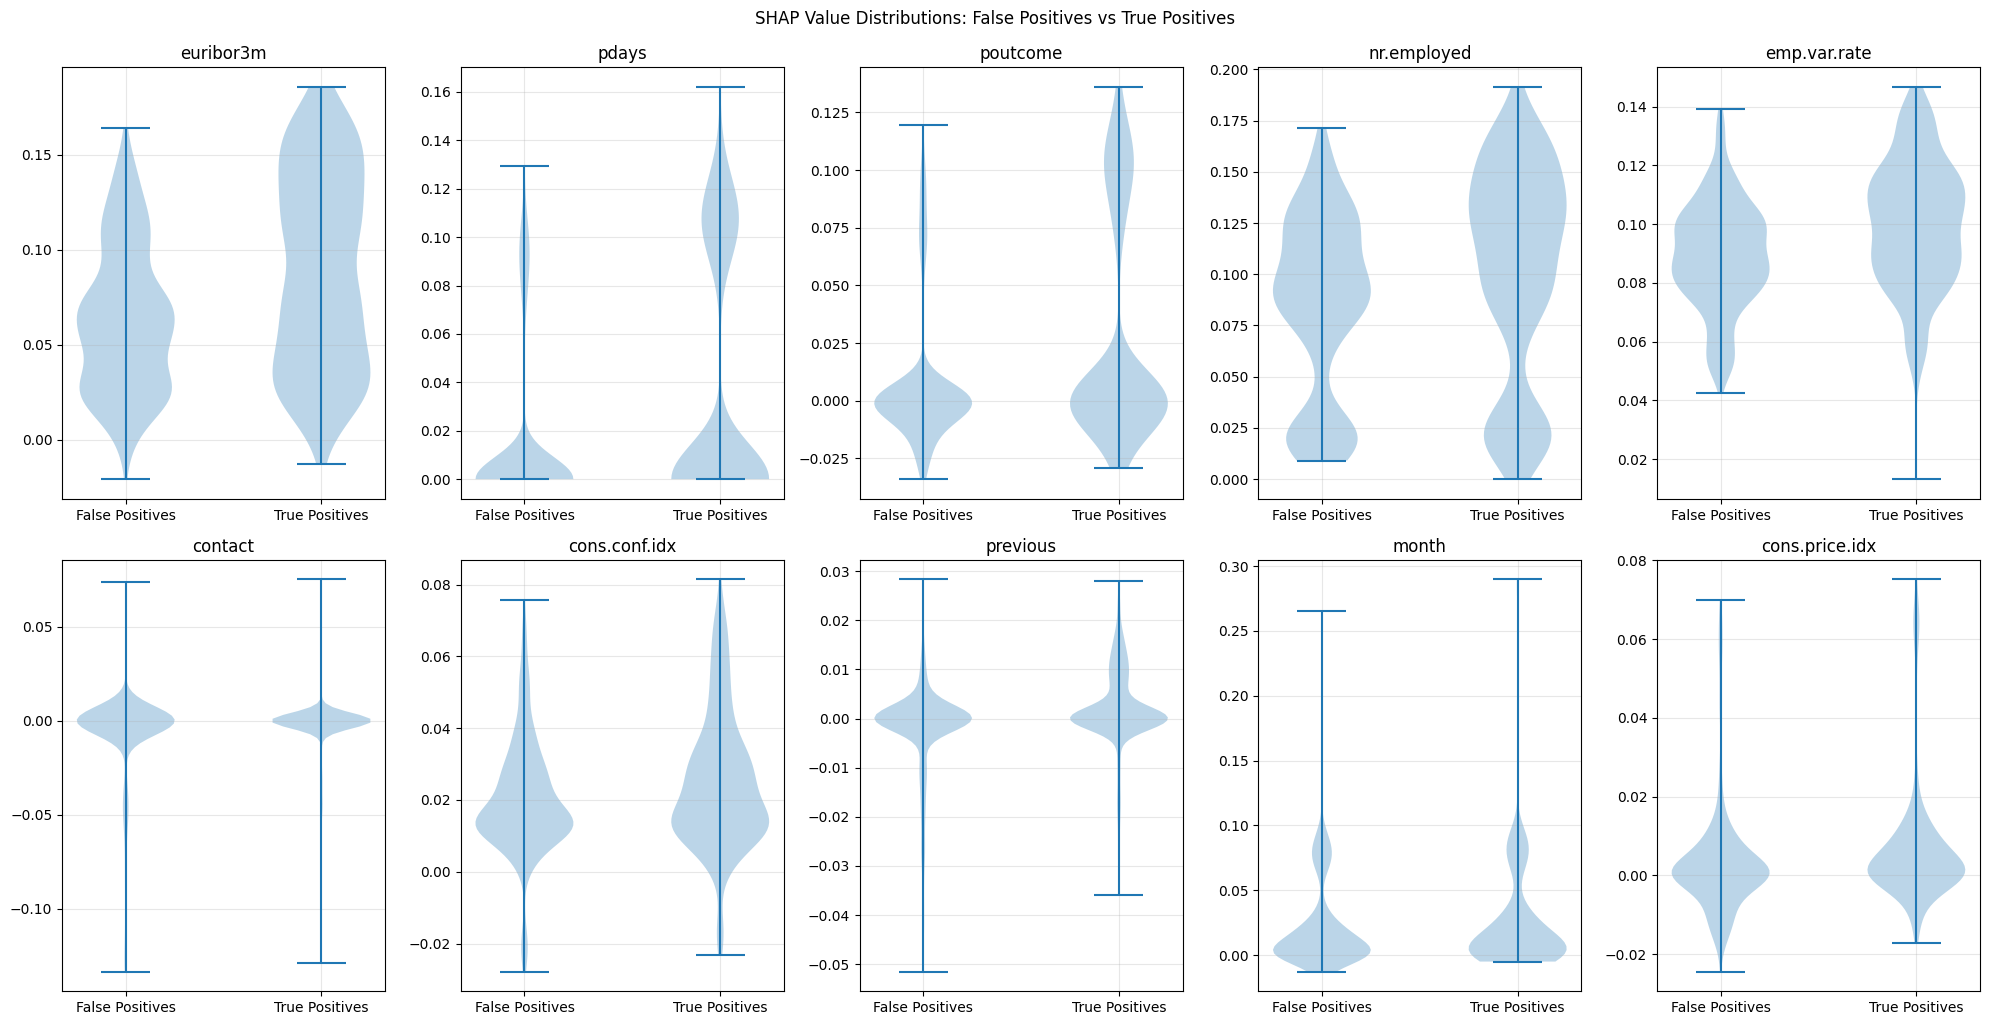

In [157]:
plot_shap_violin_comparison(
    expl1=fp_expl,
    expl2=tp_expl,
    feature_names=feature_names,
    comparison_df=comparison_df_fp_tp,
    group1_label="False Positives",
    group2_label="True Positives"
)

Again, the plots show that variables like poutcome, pdays, and even cons.conf.idx seem to help in correct predictions but are underutilized or misinterpreted in errors. Reducing overreliance on economic conditions and strengthening interpretation of interaction-based features (like pdays, poutcome, and contact) could improve the overall performance of the model.

To improve the model performance, the following strategies could be implemented:</br>
- Rebalance employment variation rate feature weight: the extreme reliance on employment rate suggests the model may be overfitting to this feature 
- Adjust class weight to predict positive class more carefully 
- Adjust classification thresholds
- Create interaction terms between employment features and other variables
- Develop composite features that combine employment status with campaign history
- Remove low-impact features to reduce noise and improve model interpretability
